# AveragePerLane.ipynb
Measuring how fast traffic on each lane drives

In [1]:
from IDMInterface import IDMSimulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from multiprocessing import Pool, Process, Value, Array

In [2]:
def average_on_lane(velocities, lane_info, lane, index):
    cars = velocities.shape[1]
    cars_on_lane = 0
    sum = 0
    for car_index in range(cars):
        if lane_info[index, car_index] == lane:
            sum += velocities[index,car_index]
            cars_on_lane += 1
    if cars_on_lane == 0:
        return 0
    return sum / cars_on_lane

def average_all_lanes(velocities,lane_info,index,lane_num=3):
    res = []
    for i in range(lane_num):
        res.append(average_on_lane(velocities, lane_info, i, index))
    res.append(np.average(velocities[index, :]))
    return res

def average_per_lane_exact(cars, length=1500, lanes=3, iterations=10, EU=False):
    steps = 30000
    fn, df = IDMSimulation(road_length=length,
                          cars=cars,
                          lanes=lanes,
                          step_width=1/30,                
                          steps=steps,
                          EU=EU)
    
    t = np.array(df['t'])
    locations = np.zeros(shape=(steps, cars))
    velocities = np.zeros(shape=(steps, cars))
    lane = np.zeros(shape=(steps, cars))

    for car_index in range(0,cars):
        for step in range(0, steps):
            locations[step, car_index] = df['x' + str(car_index)][step]
            velocities[step, car_index] = df['v' + str(car_index)][step]
            lane[step, car_index] = df['l' + str(car_index)][step]
    
    time_measured = np.zeros(iterations)
    result = np.zeros((iterations,lanes + 1))
    
    for i in range(iterations):
        result[i, :] = average_all_lanes(velocities, lane, -1 - i * 900, lane_num=lanes)
        time_measured[i] = t[-1 - i * 900]
    return time_measured, result

def average_per_lane(cars, length=1500, lanes=3, iterations=20, EU=False):
    time, ave_per_lane = average_per_lane_exact(cars, length=length, lanes=lanes, iterations=iterations, EU=EU)
    std_dev = np.std(ave_per_lane, axis=0)
    ave_per_lane = np.average(ave_per_lane, axis=0)
    return ave_per_lane, std_dev

## Creating a plot for US Law

In [3]:
lane_num = 3
ave_per_lane, std_dev = average_per_lane(5)

car_nums  = [20,25,30,35,40,45,50,55,60,70,80,90,100,110]

microscopicIDM --road-length 1500 --cars 5 --lanes 3 --step-width 0.03333333333333333 --integration-steps 30000 --output-csv /tmp/IDM/1500_5_3_0.03333333333333333_30000.csv


In [4]:
averages = np.zeros((lane_num+1, len(car_nums)))
stddevs = np.zeros_like(averages)

for i in range(len(car_nums)):
    ave, std = average_per_lane(car_nums[i], EU=False)
    averages[:, i] = ave
    stddevs[:,i] = std
    
plt.clf()

average_desired_speed = 120 * .278
desired_speed_width = .2 * 120 * .278

# plotting averages and deviation for each lane
plt.errorbar(car_nums, averages[0,:], xerr=1, yerr=stddevs[0,:], ls='none', label='Right lane')
plt.errorbar(car_nums, averages[1,:], xerr=1, yerr=stddevs[1,:], ls='none', label='Middle lane')
plt.errorbar(car_nums, averages[2,:], xerr=1, yerr=stddevs[2,:], ls='none', label='Left lane')

plt.errorbar(car_nums, averages[3,:], xerr=1, yerr=stddevs[3,:], ls='none', 
             label='Average',
            c='k')

x = np.linspace(car_nums[0] - 2, car_nums[-1] + 2)
plt.fill_between(x, average_desired_speed - desired_speed_width, average_desired_speed + desired_speed_width,
                color='r',
                alpha=.3,
                label='Desired speed distribution range')
plt.xlabel('Cars')
plt.ylabel('Average speed / (m/s)')
plt.tight_layout()
plt.legend()

plt.savefig('build/speed_lanes_US.pdf')
plt.savefig('build/speed_lanes_US.png')

## Now creating the same plot for EU

microscopicIDM --road-length 1500 --cars 20 --lanes 3 --step-width 0.03333333333333333 --integration-steps 30000 --output-csv /tmp/IDM/1500_20_3_0.03333333333333333_30000_EU.csv --EU 
microscopicIDM --road-length 1500 --cars 25 --lanes 3 --step-width 0.03333333333333333 --integration-steps 30000 --output-csv /tmp/IDM/1500_25_3_0.03333333333333333_30000_EU.csv --EU 
microscopicIDM --road-length 1500 --cars 30 --lanes 3 --step-width 0.03333333333333333 --integration-steps 30000 --output-csv /tmp/IDM/1500_30_3_0.03333333333333333_30000_EU.csv --EU 
microscopicIDM --road-length 1500 --cars 35 --lanes 3 --step-width 0.03333333333333333 --integration-steps 30000 --output-csv /tmp/IDM/1500_35_3_0.03333333333333333_30000_EU.csv --EU 
microscopicIDM --road-length 1500 --cars 40 --lanes 3 --step-width 0.03333333333333333 --integration-steps 30000 --output-csv /tmp/IDM/1500_40_3_0.03333333333333333_30000_EU.csv --EU 
microscopicIDM --road-length 1500 --cars 45 --lanes 3 --step-width 0.03333333333

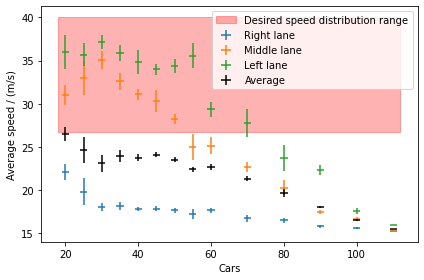

In [5]:
averages = np.zeros((lane_num+1, len(car_nums)))
stddevs = np.zeros_like(averages)

for i in range(len(car_nums)):
    ave, std = average_per_lane(car_nums[i], EU=True)
    averages[:, i] = ave
    stddevs[:,i] = std
    
plt.clf()
# plotting averages and deviation for each lane
plt.errorbar(car_nums, averages[0,:], xerr=1, yerr=stddevs[0,:], ls='none', label='Right lane')
plt.errorbar(car_nums, averages[1,:], xerr=1, yerr=stddevs[1,:], ls='none', label='Middle lane')
plt.errorbar(car_nums, averages[2,:], xerr=1, yerr=stddevs[2,:], ls='none', label='Left lane')

plt.errorbar(car_nums, averages[3,:], xerr=1, yerr=stddevs[3,:], ls='none', 
             label='Average',
            c='k')

x = np.linspace(car_nums[0] - 2, car_nums[-1] + 2)
plt.fill_between(x, average_desired_speed - desired_speed_width, average_desired_speed + desired_speed_width,
                color='r',
                alpha=.3,
                label='Desired speed distribution range')
plt.xlabel('Cars')
plt.ylabel('Average speed / (m/s)')
plt.tight_layout()
plt.legend()

plt.savefig('build/speed_lanes_EU.pdf')
plt.savefig('build/speed_lanes_EU.png')